# Epileptic Seizure Recognition

 Data Description

The following data has been downloaded from the UCI ML Repo. The following blurb has been taken directly from the data webpage (https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition)

The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds. The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have total 500 individuals with each has 4097 data points for 23.5 seconds. We divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}. The response variable is y in column 179, the Explanatory variables X1, X2, ..., X178

The categories of y pertain to:<br>
* 5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open<br>
* 4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed<br>
* 3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area<br>
* 2 - They recorder the EEG from the area where the tumor was located<br>
* 1 - Recording of seizure activity

All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest<br>
For this reason we will use a binary classification.

# Main Objective<br>
The current primary objective is to compare how dimensionality reduction (PCA) and clustering affect classification performance.<br>
I will split these into 2 discrete objectives. I will then test a few classification algos to determine the best approach to binary clf.

# Import and Load 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings 
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('../input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv', error_bad_lines=False, index_col=False, engine='python')
data=data.drop('Unnamed', axis=1) # This col is uninformative

# Exploratory Data Analysis<br>
Since all of the feature columns are not very well labelled (e.g. X1, X2, .. X177), and there are a huge number of them, I won't bother with any vis as it's not very informative.

Lets first do some basic functions to understand the data

Whats the shape of the data?

In [3]:
print(data.shape)

(11500, 179)


What columns do we have?

In [4]:
print(data.columns.tolist())

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X1

What type are the columns?

In [5]:
print(data.dtypes)
print(data.dtypes.value_counts())

X1      int64
X2      int64
X3      int64
X4      int64
X5      int64
        ...  
X175    int64
X176    int64
X177    int64
X178    int64
y       int64
Length: 179, dtype: object
int64    179
dtype: int64


Lets split the y variable into 1 (having seizure) and 0 (no seizure)

In [6]:
data['y']=np.where(data['y'] >1, 0,  1)

Is the data balanced?

In [7]:
data.y.value_counts()

0    9200
1    2300
Name: y, dtype: int64

The data is not balanced. We'll need to pay attention to the scoring metrics and stratifying splitting. I won't bother up/down sampling for this current exercise.

Do some cols have NA's?

In [8]:
print(data.isna().sum().sort_values(ascending=False))

y       0
X45     0
X65     0
X64     0
X63     0
       ..
X118    0
X117    0
X116    0
X115    0
X1      0
Length: 179, dtype: int64


Great, we're working with complete data. Lets consider the distribution/skew of features.

In [9]:
feature_cols=data.drop('y', axis=1).columns

In [10]:
log_columns = data[feature_cols].skew().sort_values(ascending=False)
to_log = log_columns.loc[log_columns > 0.75]

In [11]:
print('The number of columns which are sufficiently skewed to require transformation is: ', len(to_log))

The number of columns which are sufficiently skewed to require transformation is:  0


So we can avoid transforming at feature cols.

# Scaling<br>
Before any kind of dimension reduction we must ensure to scale the data

In [12]:
data_orig = data.copy() # quickly make a copy before we change the data too much
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
for col in data[feature_cols].columns:
    data[col] = scaler.fit_transform(data[[col]]).squeeze()
    
data.describe() # Ensure all cols are between 0-1, looks good.

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,0.512600,0.514528,0.516651,0.531055,0.538831,0.489784,0.470610,0.463088,0.471686,0.475430,...,0.509565,0.555400,0.550171,0.541099,0.514764,0.484155,0.461937,0.454312,0.485258,0.200000
std,0.046459,0.046764,0.046298,0.046650,0.048655,0.045152,0.041626,0.042384,0.041686,0.040990,...,0.045185,0.049790,0.056925,0.053358,0.046473,0.042984,0.042554,0.043160,0.044031,0.400017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500701,0.502112,0.504247,0.518079,0.524932,0.476630,0.458366,0.450458,0.459223,0.463209,...,0.497256,0.542104,0.535630,0.527699,0.503195,0.472913,0.450888,0.443031,0.473825,0.000000
50%,0.513604,0.515348,0.517554,0.531386,0.538833,0.489505,0.470224,0.462745,0.471572,0.475217,...,0.509879,0.555889,0.551165,0.542260,0.515699,0.485213,0.462905,0.455220,0.486111,0.000000
75%,0.525386,0.527457,0.529728,0.544113,0.551828,0.501819,0.481310,0.474248,0.482634,0.486012,...,0.521679,0.569074,0.565687,0.555872,0.527924,0.496467,0.474138,0.466614,0.497596,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Baseline classification score<br>
In order to test the influence of PCA and clustering, we should first (a) find which clf algo we will use and (b) check what score we can get with a basic baseline model.

 Preparing data for ML

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
X=data.drop('y', axis=1)
y=data.y

In [17]:
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

Get the index values from the generator

In [18]:
train_idx, test_idx = next(strat_shuff_split.split(X, y))

Create the data sets

In [19]:
X_train = data.loc[train_idx, X.columns.values]
y_train = data.loc[train_idx, 'y']

In [20]:
X_test = data.loc[test_idx, X.columns.values]
y_test = data.loc[test_idx, 'y']

Ensure the train/test split is equal

In [21]:
print(y_train.value_counts(normalize=True).sort_index())

0    0.8
1    0.2
Name: y, dtype: float64


Test

In [22]:
print(y_test.value_counts(normalize=True).sort_index())

0    0.8
1    0.2
Name: y, dtype: float64


Perfect! Lets get classifying...<br>
We'll consider the F1 score as our primary indicator because it deals well with unbalanced data sets by comparing both precision and recall.

# Classification

Lets see what performance we can get with a baseline model. This should help us pick our classifier algorithm.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,  QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, precision_score, recall_score, f1_score, roc_auc_score

In [24]:
classifiers = [
    LogisticRegression(),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier()]

In [25]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    
    # calculate score
    acc = accuracy_score(y_test, train_predictions)
    precision = precision_score(y_test, train_predictions, average = 'macro') 
    recall = recall_score(y_test, train_predictions, average = 'macro') 
    f_score = f1_score(y_test, train_predictions, average = 'macro')
    
    print("Precision: {:.4%}".format(precision))
    print("Recall: {:.4%}".format(recall))
    print("F-score: {:.4%}".format(recall))
    print("Accuracy: {:.4%}".format(acc))
    
print("="*30)

LogisticRegression
****Results****
Precision: 90.2450%
Recall: 51.5217%
F-score: 51.5217%
Accuracy: 80.6087%
SVC
****Results****
Precision: 94.0349%
Recall: 87.7174%
F-score: 87.7174%
Accuracy: 94.3043%
DecisionTreeClassifier
****Results****
Precision: 91.1514%
Recall: 90.6793%
F-score: 90.6793%
Accuracy: 94.2174%
RandomForestClassifier
****Results****
Precision: 96.9468%
Recall: 96.7935%
F-score: 96.7935%
Accuracy: 98.0000%
GradientBoostingClassifier
****Results****
Precision: 95.9919%
Recall: 92.8261%
F-score: 92.8261%
Accuracy: 96.4783%
MLPClassifier
****Results****
Precision: 95.8184%
Recall: 90.6522%
F-score: 90.6522%
Accuracy: 95.7391%


From the above, it looks like Random Forest gives us our best F1 score at around 96. Lets see if we can improve with PCA/Clustering.

## Principle Component Analysis<br>
First, we'll consider the number of components we should use to get a reasonable explanation of the data.

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca_list = list()
feature_weight_list = list()

Fit a range of PCA models

In [28]:
for n in range(2, 30):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(data)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': data.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
print (pca_df)

                   model       var
n                                 
2    PCA(n_components=2)  0.332313
3    PCA(n_components=3)  0.371588
4    PCA(n_components=4)  0.407797
5    PCA(n_components=5)  0.443204
6    PCA(n_components=6)  0.474868
7    PCA(n_components=7)  0.504209
8    PCA(n_components=8)  0.532821
9    PCA(n_components=9)  0.559175
10  PCA(n_components=10)  0.584251
11  PCA(n_components=11)  0.608924
12  PCA(n_components=12)  0.632315
13  PCA(n_components=13)  0.654874
14  PCA(n_components=14)   0.67607
15  PCA(n_components=15)  0.696916
16  PCA(n_components=16)  0.715465
17  PCA(n_components=17)  0.732473
18  PCA(n_components=18)  0.747341
19  PCA(n_components=19)  0.762519
20  PCA(n_components=20)   0.77684
21  PCA(n_components=21)  0.790983
22  PCA(n_components=22)  0.804741
23  PCA(n_components=23)  0.817643
24  PCA(n_components=24)   0.83037
25  PCA(n_components=25)  0.842332
26  PCA(n_components=26)  0.853485
27  PCA(n_components=27)   0.86452
28  PCA(n_components

Lets plot to see if there's any visual elbow

In [29]:
pca_df['factors']=pca_df.index
pca_df['var'] = pd.to_numeric(pca_df['var'], errors='coerce')

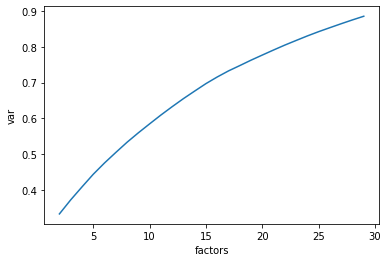

In [30]:
sns.lineplot(data=pca_df, x='factors', y='var')

No clear elbow is available. Lets run through a range of PCA values and see where the clf model gets us.

# Finding the ideal PCA clusters

In [31]:
from sklearn.pipeline import Pipeline
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [32]:
def get_avg_score(n):
    pipe = [
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=n)),
        ('estimator', RandomForestClassifier())
    ]
    pipe = Pipeline(pipe)
    f1_scores = []
    for train_index, test_index in strat_shuff_split.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe.fit(X_train, y_train)
        f1_scores.append(f1_score(y_test, pipe.predict(X_test)))
    return np.mean(f1_scores)

In [33]:
ns = [5, 10, 20, 30, 40, 50, 100]
score_list = [get_avg_score(n) for n in ns]
print(score_list)

[0.8978260869565218, 0.9192680301399354, 0.9314775160599572, 0.9375, 0.9397849462365591, 0.9376344086021504, 0.9381107491856677]


 Visualising the Influence of n Components on F1 score

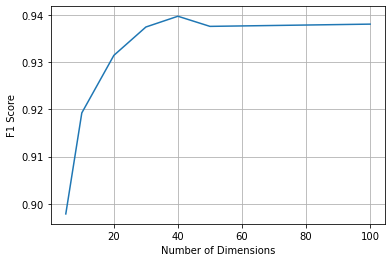

In [34]:
ax = plt.axes()
ax.plot(ns, score_list)
ax.set(xlabel='Number of Dimensions',
       ylabel='F1 Score')
ax.grid(True)

From the above plot we can see that we achieve a very high score with as few as 40 components. If rapid computation is requied, we may consider using PCA to greatly reduce the features. 

## Clustering<br>
Next I will consider whether adding a cluster variable functions to improve the performance above the basic baseline RF model.<br>
First, lets work out how many clusters are required, by looping through clusters and using the elbow method. I will begin withna basic K-means

In [35]:
from sklearn.cluster import KMeans

In [36]:
kmeans_list = list()

In [37]:
for clusters in range(1,15):
    km = KMeans(n_clusters=clusters, random_state=42)
    km = km.fit(data[feature_cols])
    
    kmeans_list.append(pd.Series({'clusters': clusters, 
                              'inertia': km.inertia_,
                              'model': km}))
# Prepare to plot    
elbow_graph_data = (pd.concat(kmeans_list, axis=1)
             .T
             [['clusters','inertia']])
elbow_graph_data[['clusters','inertia']]=elbow_graph_data[['clusters','inertia']].apply(pd.to_numeric, errors='coerce')

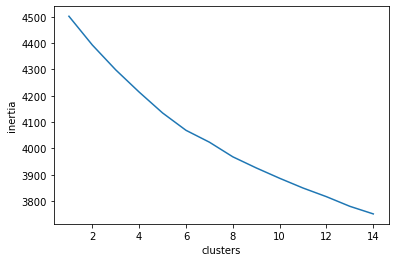

In [38]:
sns.lineplot(data=elbow_graph_data, x='clusters', y='inertia')

Theres really no clear elbow here. However, we do have domain knowledge- these features relate to 5 y classifications therefore there should technically be 5 clusters. Lets use this.

In [39]:
km = KMeans(n_clusters=5, random_state=42)
km = km.fit(data[feature_cols])

In [40]:
data['km_cluster'] = km.predict(data[feature_cols])

For good measure, lets investigate hierarchial clustering too.

In [41]:
from sklearn.cluster import AgglomerativeClustering
AClust = AgglomerativeClustering(n_clusters=5, linkage='ward')
AClust = AClust.fit(data[feature_cols])
data['AClust'] = AClust.fit_predict(data[feature_cols])

Now lets run the model with KM and AC clusters.

In [42]:
data_KM=data.drop(['AClust'], axis=1)
data_AG=data.drop(['km_cluster'], axis=1)
data_no_clusters=data.drop(['AClust', 'km_cluster'], axis=1)

# Influence of Clustering on RF Performance

In [43]:
def test_clusters(estimator, X, y):
    f1_scores = []
    for train_index, test_index in strat_shuff_split.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        estimator.fit(X_train, y_train)
        f1_scores.append(f1_score(y_test, estimator.predict(X_test)))
    return np.mean(f1_scores)

In [44]:
f1_with_kmeans = test_clusters(RandomForestClassifier(), data_KM, y)
f1_with_hierarchial = test_clusters(RandomForestClassifier(), data_AG, y)
f1_with_no_clustering = test_clusters(RandomForestClassifier(), data_no_clusters, y)

In [45]:
print('F1 score with K-means clustering:', f1_with_kmeans)
print('F1 score with hierarchial clustering:', f1_with_hierarchial)
print('F1 score with no clustering:', f1_with_no_clustering)

F1 score with K-means clustering: 0.9978308026030369
F1 score with hierarchial clustering: 1.0
F1 score with no clustering: 0.9978308026030369


Here we see a very small improvement with clustering but the effect is minor as the performance is already maxed out.

# Suggestions for next steps.<br>
The baseline model was already very strong here. A couple of extra steps that could be worthy:<br>
* Tuning the RF model to get optimal performance from the hyperparameters<br>
* Combining PCA and clustering in order to greatly reduce n features (improving compute speed and scalability)<br>
* Building ensemble models may potentially help. Though we are near perfect performance at this point.